In [384]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import cvxpy as cp
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

abspath = os.path.abspath(os.getcwd())
finpath = Path(abspath).resolve().parent
parent_path = str(finpath) + '/'

final_df = pd.read_csv(parent_path + "FinalDF.csv")
adj_counties = pd.read_csv(parent_path + "AdjacentDelta.csv")
final_df["Population"] = np.sqrt(final_df["Population"]) / np.sqrt(final_df["Population"].max()) #Ask about specific transformation for weighting to use here

In [2]:
def standardize_df(df):
    df = df.select_dtypes(exclude=['object'])
    feature_cols = df.columns[2:]
    std_final_df = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:, 2:]), columns=feature_cols)
    pop_df = df["Population"]
    return std_final_df, pop_df

def shuffle_data(data, labels, p):
    indices = np.random.permutation(len(data))
    return data[indices], labels[indices], p[indices]

def split_data(data, labels, p):
    size = len(data)
    index_eighty = int(size*0.8)
    train_data = data[:index_eighty]
    train_labels = labels[:index_eighty]
    train_p = p[:index_eighty]
    test_data = data[index_eighty:]
    test_labels = labels[index_eighty:]
    test_p = p[index_eighty:]
    return train_data, train_labels, train_p, test_data, test_labels, test_p

In [273]:
median_income = final_df["Median Household Income"].median()
df_upper_income = final_df[final_df["Median Household Income"] >= median_income]
df_lower_income = final_df[final_df["Median Household Income"] < median_income]
#print(df_upper_income["Population"])
#print(df_lower_income.shape)

# Here, our dataframes are not the same shapes because % Completed High School has many values at the median,
# but the number of observations in the dataframes are 1197 for the upper bracket and 1209 for the lower bracket,
# which we found to be acceptable for running our regression analysis on
median_edu = final_df["% Completed High School"].median()
df_upper_edu = final_df[final_df["% Completed High School"] > median_edu]
df_lower_edu = final_df[final_df["% Completed High School"] <= median_edu]

# Adjacent counties regression

adj_counties = adj_counties.select_dtypes(exclude=['object'])


# Standardizing values and creating all the matrices we need to run Lasso

df_lst = [final_df, df_upper_income, df_lower_income, df_upper_edu, df_lower_edu, adj_counties] #Want to add adj_counties to this list after Population column is added
params_lst = []
for frame in df_lst:
    std_frame, pop_df = standardize_df(frame)
    label_df = std_frame["% Smokers"]
    IV_df = std_frame["Cig Tax Rate"]
    features_df = std_frame.drop(columns=["% Smokers", "Cig Tax Rate"])
    p = np.array([pop_df]).T
    X = np.array(features_df)
    IV = np.array([IV_df]).T
    y = np.array([label_df]).T
    values = [X, IV, y, p]
    params_lst.append(values)

In [5]:
def cross_validation(params, lower, upper, lambdas, folds):
    X, IV, y, p = params
    lams = np.linspace(lower, upper, lambdas)
    error_lst = []
    gen_params_lst = []
    min_error = 100000000
    best_lam = None
    for _ in range(folds):
        X_s, y_s, p_s = shuffle_data(X, y, p)
        gen_params = split_data(X_s, y_s, p_s)
        gen_params_lst.append(gen_params)
    for lam in lams:
        sum_error = 0
        for gen_params in gen_params_lst:
            train_X, train_y, train_p, test_X, test_y, test_p = gen_params
            B = cp.Variable((train_X.shape[1], 1))
            objective = cp.Minimize(((train_y - train_p.T @ train_X @ B) ** 2) + lam * cp.norm1(B))
            constraints = []
            prob = cp.Problem(objective, constraints)
            prob.solve()
            betas = np.array(B.value)
            error = (((test_y - test_p.T @ test_X @ betas) ** 2))
            sum_error += float(error)
        if sum_error < min_error:
            min_error = sum_error
            best_lam = lam
        error_lst.append(sum_error)
    print(best_lam)
    plt.plot(lams, error_lst)
    plt.show()


0.0


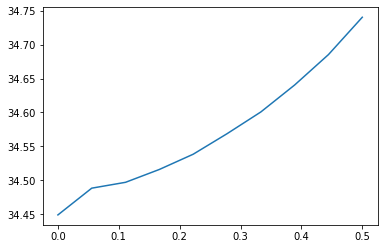

In [190]:
cross_validation(params_lst[0], 0, 0.5, 10, 10)

1.0


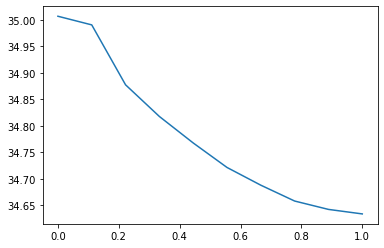

In [191]:
cross_validation(params_lst[1], 0.0, 1, 10, 10)

1.0


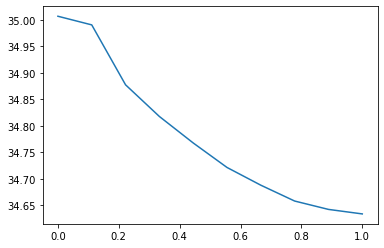

In [ ]:
cross_validation(params_lst[1], 0.0, 1, 10, 10)

0.08080808080808081


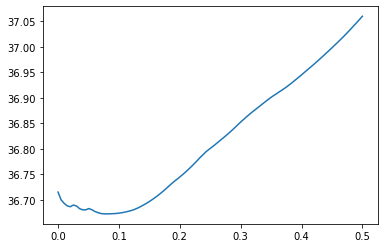

In [157]:
cross_validation(params_lst[2], 0.0, 0.5, 100, 20)

0.4040404040404041


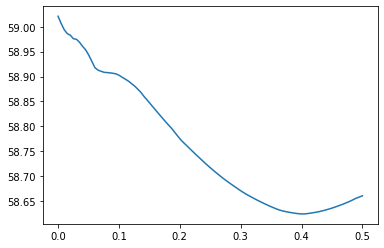

In [158]:
cross_validation(params_lst[3], 0.0, 0.5, 100, 20)

0.6262626262626263


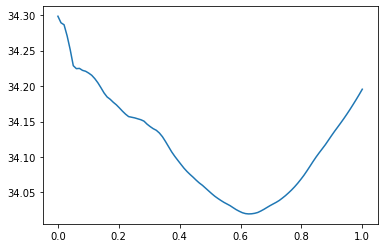

In [159]:
cross_validation(params_lst[4], 0.0, 1, 100, 20)

In [195]:
def cross_validation2(params, lower, upper, lambdas, folds):
    X, IV, y, p = params
    lams = np.linspace(lower, upper, lambdas)
    error_lst = []
    gen_params_lst = []
    min_error = 100000000
    best_lam = None
    for _ in range(folds):
        IV_s, y_s, p_s = shuffle_data(IV, y, p)
        gen_params = split_data(IV_s, y_s, p_s)
        gen_params_lst.append(gen_params)
    for lam in lams:
        sum_error = 0
        for gen_params in gen_params_lst:
            train_IV, train_y, train_p, test_IV, test_y, test_p = gen_params
            B = cp.Variable((train_IV.shape[1], 1))
            objective = cp.Minimize(( (train_y - train_p.T @ train_IV @ B) ** 2) + lam * cp.norm1(B))
            constraints = []
            prob = cp.Problem(objective, constraints)
            prob.solve()
            betas = np.array(B.value)
            error = (((test_y - test_p.T @ test_IV @ betas) ** 2))
            sum_error += float(error)
        if sum_error < min_error:
            min_error = sum_error
            best_lam = lam
        error_lst.append(sum_error)
    print(best_lam)
    plt.plot(lams, error_lst)
    plt.show()


0.11111111111111112


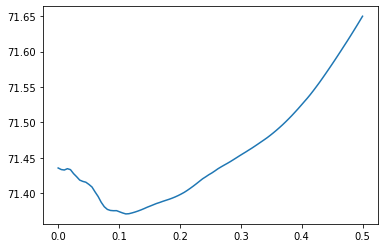

In [163]:
cross_validation(params_lst[0], 0.0, 0.5, 100, 20)

In [196]:
cross_validation2(params_lst[1], 0.0, 1, 10, 10)

ValueError: The 'minimize' objective must resolve to a scalar.

0.10606060606060606


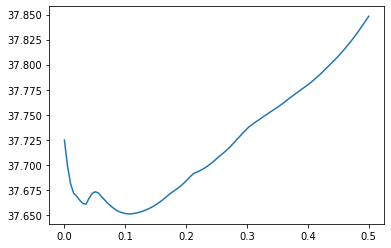

In [165]:
cross_validation(params_lst[2], 0.0, 0.5, 100, 20)

0.4545454545454546


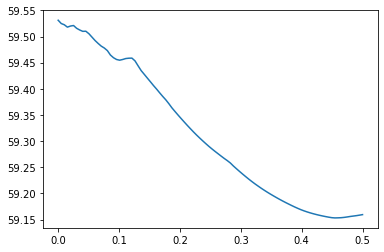

In [166]:
cross_validation(params_lst[3], 0.0, 0.5, 100, 20)

0.08080808080808081


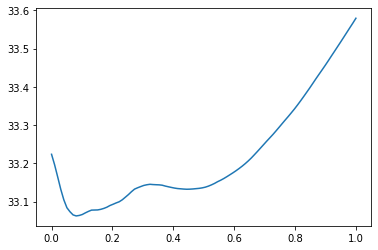

In [167]:
cross_validation(params_lst[4], 0.0, 1, 100, 20)

In [326]:
def lasso_IV(lambda_IV, params):
    X, y, IV, p = params
    model = Lasso(alpha=lambda_IV, max_iter=10000).fit(X, IV.ravel())
    betas_IV = np.array(model.coef_)
    return betas_IV

def lasso_y(lambda_y, params):
    X, y, IV, p = params
    model = Lasso(alpha=lambda_y, max_iter=10000).fit(X, y.ravel())
    betas_y = np.array(model.coef_)
    return betas_y

def OLS(betas_IV, betas_y, params):
    X, y, IV, p = params
    betas = abs(betas_y) + abs(betas_IV)
    betadict = {k: v for k, v in enumerate(betas.tolist())}
    relevantbetadict = {k:v for (k, v) in betadict.items() if v >= 10 ** -5}
    covariates = ((betas >= 10 ** -5)).flatten()
    relevantbetadict[48] = betas[0] 
    X_cov = np.concatenate((IV, X[:, covariates]), axis=1)
    model = sm.OLS(y, pd.DataFrame(X_cov, columns=[generated.columns.tolist()[2:][i] for i in relevantbetadict.keys()]))
    results = model.fit()
    betas = results.params
    relevantbetadict[48] = betas[0] 
    return betas, relevantbetadict, results

def double_lasso(lambda_IV, lambda_y, params):
    betas_IV = lasso_IV(lambda_IV, params)
    betas_y = lasso_y(lambda_y, params)
    betas, relevantbetadict, results = OLS(betas_IV, betas_y, params)


    return betas, relevantbetadict, results

def getlambdas():
    lambdaIV = []
    lambdaY = []
    for param in params_lst:
        CV = LassoCV(cv=10, max_iter=10000).fit(param[0], param[2].ravel())
        CV2 = LassoCV(cv=10, max_iter=10000).fit(param[0], param[1].ravel())

        lambdaY.append(CV.alpha_)
        lambdaIV.append(CV2.alpha_)

    return lambdaY, lambdaIV

lambdaY, lambdaIV = getlambdas()

In [327]:
labels = pd.read_csv(parent_path + "\\CorrMatrix.csv").columns.tolist()[2:]
# print(len(labels))

for index in range(len(params_lst)):
    beta, relevant, results = double_lasso(lambdaIV[index], lambdaY[index], params_lst[index])
    print(results.summary())

    # print(f"Betas for dataframe {index + 1}:")
    # for key in relevant.keys():
    #     print(f"{labels[key]}: {relevant[key]}")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.481
Model:                            OLS   Adj. R-squared (uncentered):              0.471
Method:                 Least Squares   F-statistic:                              49.74
Date:                Tue, 31 May 2022   Prob (F-statistic):                   8.09e-299
Time:                        04:40:15   Log-Likelihood:                         -2625.1
No. Observations:                2406   AIC:                                      5338.
Df Residuals:                    2362   BIC:                                      5593.
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [456]:
# Testing accuracy of different types of models on generated data

def normmeans(frame):

    normalfits = []
    for column in frame.columns.tolist()[1:]:
        data = frame[column].to_numpy()

        mu, std = norm.fit(data)
        normalfits.append(mu)

    return normalfits

def DGP():
    frame = pd.read_csv(parent_path + "\\FinalDF.csv")
    frame.drop(columns=["State", "County", "Population"], inplace=True)
    means = np.array(normmeans(frame))
    cov = pd.read_csv(parent_path + "\\CovMatrix.csv").to_numpy()[:, 1:]

    data = np.random.multivariate_normal(means, cov, size=cov.shape[0])
    
    resultframe = pd.DataFrame(data, columns=frame.columns.tolist()[1:])
    # print(resultframe)

    return resultframe

# This can be put in a for loop to generate many samples, then call testmodel on each sample, record average error, 

generated = DGP()
scaler = StandardScaler()
generatedy = generated["% Smokers"].to_numpy().reshape(-1, 1)
generatedy = pd.DataFrame(scaler.fit_transform(generatedy), columns=["% Smokers"])
X = generated.drop(columns=["% Smokers"])
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns.tolist())

X_train, X_test, y_train, y_test = train_test_split(X[X.columns.tolist()[1:]], generatedy)

def trainmodel(xtrain, ytrain, modelname):
    if modelname == "OLS":
        model = sm.OLS(ytrain, xtrain)
        results = model.fit()

        return results.params.tolist()
    elif modelname == "Lasso":
        CV = LassoCV(cv=10, max_iter=10000).fit(xtrain, ytrain.ravel())
        # print(f"Lambda: {CV.alpha_}")
        model = Lasso(alpha=CV.alpha_, max_iter=10000).fit(xtrain, ytrain.ravel())
        betas = np.array(model.coef_)

        # print(betas)
        return betas
    elif modelname == "DLasso":
        IVtrain = xtrain.to_numpy()[:, -1]
        IVtrain.reshape(len(IVtrain), 1)
        CV = LassoCV(cv=10, max_iter=10000).fit(xtrain, IVtrain.ravel())
        model = Lasso(alpha=CV.alpha_, max_iter=10000).fit(xtrain, IVtrain.ravel())
        c1 = np.array(model.coef_)

        CV2 = LassoCV(cv=10, max_iter=10000).fit(xtrain, IVtrain.ravel())
        model = Lasso(alpha=CV.alpha_, max_iter=10000).fit(xtrain, ytrain.ravel())
        c2 = np.array(model.coef_)

        union = np.add(abs(c1), abs(c2))
        print(union.shape)
        covariates = ((union >= 10 ** -5)).flatten()
        # print(xtrain.to_numpy())
        X_cov = np.concatenate((np.vstack(IVtrain), xtrain.to_numpy()[:, covariates]), axis=1)

        model = sm.OLS(ytrain, X_cov)
        results = model.fit()

        return results.params.tolist()



def testmodel(xtest, ytest, xtrain, ytrain, modelname):
    beta = np.array(trainmodel(xtrain, ytrain, modelname)).reshape(-1, 1)

    y = np.array(ytest).reshape(-1, 1)
    X = np.array(xtest)

    error = y - X @ beta
    avgerror = np.average(abs(error))

    return avgerror

def getstats():
    OLSerr = []
    Lassoerr = []
    DLassoerr = []
    for _ in range(100):
        generated = DGP()
        scaler = StandardScaler()
        generatedy = generated["% Smokers"].to_numpy().reshape(-1, 1)
        generatedy = pd.DataFrame(scaler.fit_transform(generatedy), columns=["% Smokers"]).to_numpy()
        X = generated.drop(columns=["% Smokers"])
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns.tolist())
        X_train, X_test, y_train, y_test = train_test_split(X[X.columns.tolist()[1:]], generatedy)
        OLSerr.append(testmodel(X_test, y_test, X_train, y_train, "OLS"))
        Lassoerr.append(testmodel(X_test, y_test, X_train, y_train, "Lasso"))
        # DLassoerr.append(testmodel(X_test, y_test, X_train, y_train, "DLasso"))
    
    totalavgOLS = np.average(abs(np.array(OLSerr)))
    totalavgLasso = np.average(abs(np.array(Lassoerr)))

    print(f"Average Error across all samples (OLS): {totalavgOLS}")
    print(f"Average Error across all samples (Lasso): {totalavgLasso}")



getstats()






c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.
c:\Users\spont\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semide

Average Error across all samples (OLS): 0.6200991725949642
Average Error across all samples (Lasso): 0.3665562318298825
